# Trabalho Prático 01 - Machine Learning

## Introdução

Neste trabalho você irá implementar uma rede neuronal com três camadas:

1. Camada de entrada: cada unidade representa uma dimensão do dado de entrada.

2. Camada oculta: cada unidade representa uma transformação a partir das unidades de entrada.

3. Camada de saída: cada unidade representa a chance da saída correspondente ser a correta.

Você irá utilizar a função Sigmóide para obter não-linearidade. Além disso, a função de perda a ser minimizada é a seguinte:

![title](t2.jpg)

onde m é a quantidade de entradas no treino, K é o número de saídas possíveis, representa a saída correta de cada classe k em cada entrada (i), e similarmente representa a saída dada pela rede neuronal.

O dado a ser utilizado está anexado. Trata-se de 5000 entradas, onde cada entrada refere-se a um dígito escrito manualmente (i.e., MNIST dataset). Dessa forma, m=5000 e K=10. Cada entrada é dada por uma matriz de dimensões 28 por 28, ou seja, um vetor de 784 dimensões. A primeira coluna do arquivo sempre é o rótulo do dígito correto.

A rede neuronal a ser implementada deverá ter 784 unidades de entrada e 10 unidades de saída. Em seus experimentos, você deverá variar o número de unidades na camada oculta (25, 50, 100).

Além disso, você deverá comparar os seguintes algoritmos de cálculo de gradiente:

1. Gradient Descent: o gradiente é calculado após cada época (após as 5000 entradas serem processadas).

2. Stochastic Gradient Descent: o gradiente é calculado após cada entrada.

3. Mini-Batch: o gradiente é calculado após um certo número de entradas (considere 10 e 50).

Por fim, você também deverá variar a taxa de aprendizado: 0.5, 1, 10.

O documento a ser entregue deverá apresentar o resultado de seus experimentos. Ou seja, deverá apresentar discussão da variação do número de unidades na camada oculta para cada um dos três algoritmos de cálculo de gradiente. Você deverá apresentar gráficos mostrando a convergência do erro empírico para cada situação (unidades na camada oculta, algoritmo de cálculo do gradiente, taxa de aprendizado). Você deverá deixar claras todas as hipóteses que julgar serem pertinentes.

## Resolução

In [28]:
import tensorflow as tf
import numpy as np
from numpy import genfromtxt

int_classes   = []
vetor_numeros = []
vetor_classes = []

### LEITURA DE DADOS ###
arquivo = genfromtxt('./data_tp1', delimiter=',', autostrip=True, dtype=int)

for x in range(1, 4999):
    linha  = np.array(arquivo[x-1:x])       #np array 'linha' contendo a linha (785 itens)
    classe = np.resize(linha, (1,1))        #aqui, pegamos o primeiro valor de 'linha'
    
    linha_escalar = linha.ravel()           #escalar da linha com os 785 itens
    numero = linha_escalar[1:785:1]         #escalar do numero, sem o primeiro item (784 itens)

    int_classes.append(int(classe))         #adiciono a classe no vetor de classes
    vetor_numeros.append(np.array(numero))  #adiciono o numero no vetor de numeros

In [30]:
sess = tf.InteractiveSession()

def experimento(taxa_aprendizado=0.5, unidades_camada_oculta=25, numero_epocas=10, batch_size=500): 

    X = tf.placeholder(tf.float32, shape=[None, 784], name='DadoEntrada') #shape da mnist 28*28=784
    Y = tf.placeholder(tf.float32, shape=[None, 10],  name='DadoSaida')   #10 classes de saida, 0 a 9 

    #Peso(W) e vies(b) para a camada oculta
    W1 = tf.Variable(tf.random_normal([784, unidades_camada_oculta]), dtype=tf.float32, name='Weights')
    b1 = tf.Variable(tf.random_normal([unidades_camada_oculta]), dtype=tf.float32, name='biases')

    #Peso(W) e vies(b) para a camada de saida
    W2 = tf.Variable(tf.random_normal([unidades_camada_oculta, 10]), dtype=tf.float32, name='Weights')
    b2 = tf.Variable(tf.random_normal([10]),                         dtype=tf.float32, name='biases')


    ### CONVERTENDO CLASSES EM VETORES ONE-HOT ###

    #Para cada inteiro do vetor 'int_classes', crio um array de 10 posicoes representando os numeros de 0 a 9, com 0 em todas casas, menos na que representa o numero daquela classe, que tera o numero 1
    vetor_classes = np.eye(10, dtype=int)[int_classes]  ###

    ### MODELO DE REDE ####
    def mnist(X):
        h1           = tf.nn.sigmoid(tf.matmul(X, W1) + b1)
        camada_saida = tf.matmul(h1, W2) + b2
        return camada_saida

    #Construindo modelo de rede
    logits = mnist(X)

    funcao_perda = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=logits))
    otimizador_gradiente_descendente = tf.train.GradientDescentOptimizer(taxa_aprendizado).minimize(funcao_perda)

    ### INICIALIZAR VARIAVEIS ###
    init = tf.global_variables_initializer()
    lista_acuracias = []
    
    with tf.Session() as sess:
        sess.run(init)                          #chama o inicializador das variaveis
        for epoca in range(numero_epocas):
            inicio      = 0
            fim         = 0
            total_batch = int(5000/batch_size)

            #for i in range(total_batch):    
            while inicio < len(vetor_numeros):
                fim   += batch_size
                batch  = []

                numero = np.asarray(vetor_numeros[inicio:fim])
                batch.append(numero)

                classe = np.asarray(vetor_classes[inicio:fim])
                batch.append(classe)

                otimizador_gradiente_descendente.run(feed_dict={X: batch[0], Y:batch[1]})
                inicio += batch_size

            ### TESTE DO MODELO ###
            predicao_modelo = tf.nn.softmax(logits)
            predicao_correta = tf.equal(tf.argmax(predicao_modelo, 1), tf.argmax(Y, 1))

            ### CALCULO DA ACURACIA ###
            perda = funcao_perda.eval(feed_dict={X: vetor_numeros, Y: vetor_classes})
            acuracia = tf.reduce_mean(tf.cast(predicao_correta, tf.float32))
            #print("Epoca: %d, Perda: %.2f" % (epoca+1, perda))
            #print("Acuracia obtida: ", 100*acuracia.eval(feed_dict={X: vetor_numeros, Y: vetor_classes}))
            lista_acuracias.append(100*acuracia.eval(feed_dict={X: vetor_numeros, Y: vetor_classes}))
        return lista_acuracias

/home/luisa/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [35]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (12,6)

def print_results(results):
     # summarize history for accuracy
    for key in results.keys():
        plt.plot(results[key])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(results.keys(), loc='lower right')
    plt.show()



Acuracia final: 48.83953630924225
Acuracia final: 51.86074376106262
Acuracia final: 10.744297504425049


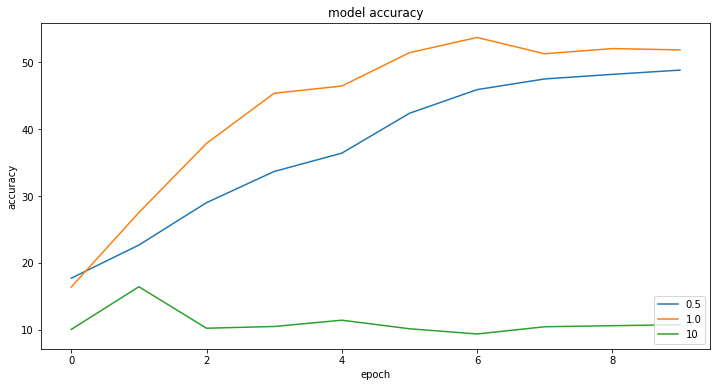

In [36]:
taxa_aprendizado = [0.5, 1.0, 10]
resultado = {}
for taxa in taxa_aprendizado:
    result = experimento(taxa)
    print("Acuracia final: "+str(result[-1]))
    resultado[str(taxa)] = result
print_results(resultado)

Acuracia final: 43.237295746803284
Acuracia final: 54.82192635536194
Acuracia final: 11.024409532546997


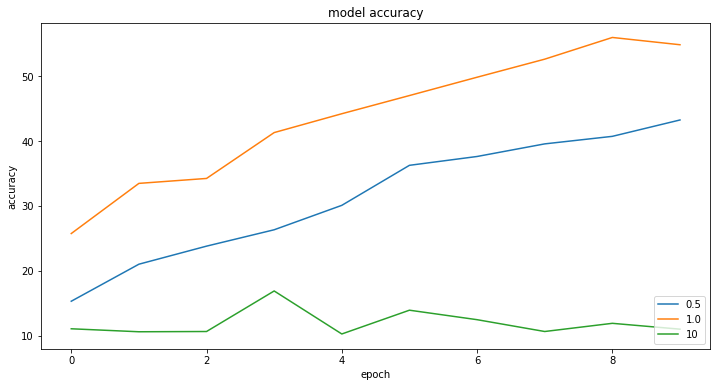

In [38]:
unidades_camada_oculta = [25, 50, 100]
resultado = {}
for taxa in taxa_aprendizado:
    result = experimento(taxa)
    print("Acuracia final: "+str(result[-1]))
    resultado[str(taxa)] = result
print_results(resultado)

Acuracia final: 49.71988797187805
Acuracia final: 56.66266679763794
Acuracia final: 24.98999536037445


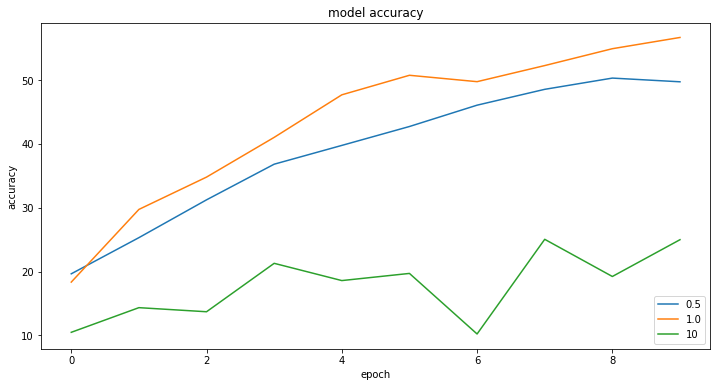

In [39]:
batch_size = [1, 10, 50, 5000]
resultado = {}
for taxa in taxa_aprendizado:
    result = experimento(taxa)
    print("Acuracia final: "+str(result[-1]))
    resultado[str(taxa)] = result
print_results(resultado)